In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Loaders

### Dataset for Returning Image and Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, classification=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.classification = classification
        bins = [18, 28, 40]
       # Add a 'label' column to the DataFrame
        if self.classification:
            self.data['label'] = self.data['real_age'].apply(
                lambda age: 0 if age <= bins[0] else 
                            1 if age <= bins[1] else 
                            2 if age <= bins[2] else 
                            3
            )

            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to(device)
        image = image.float() / image.max() # 255.0 # try normalising by max value in image
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations for Data Augmentation and Normalisation

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8,1.0)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Create Dataset from CSV

In [5]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, classification=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, classification=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, classification=True)

In [6]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Classes: {train_dataset.classes}.")


Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828
Classes: [0, 3, 1, 2].


### Stratification

In [7]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
print(f"Class counts: \n{class_counts}\n")
class_weights = 1.0 / class_counts
print(f"Class weights: \n{class_weights}\n")
sample_weights = train_dataset.data['label'].map(class_weights)
print(f"Sample weights: \n{sample_weights}\n")

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class counts: 
label
1    1167
2     971
3     934
0     848
Name: count, dtype: int64

Class weights: 
label
1    0.000857
2    0.001030
3    0.001071
0    0.001179
Name: count, dtype: float64

Sample weights: 
0       0.001179
1       0.001179
2       0.001071
3       0.001071
4       0.001179
          ...   
3915    0.001071
3916    0.001071
3917    0.001030
3918    0.000857
3919    0.000857
Name: label, Length: 3920, dtype: float64



### Creating Loaders

In [8]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

### Display Batches

Images batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])
Image Classes: tensor([0, 2, 1, 0, 2, 2, 2, 1, 1, 3, 2, 0, 1, 2, 1, 1, 0, 3, 2, 2, 1, 1, 2, 0,
        2, 3, 1, 3, 3, 0, 1, 0, 2, 2, 0, 2, 3, 1, 3, 2, 2, 0, 0, 2, 3, 3, 2, 3,
        2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 3, 3, 1, 3, 1, 1,
        1, 0, 1, 0, 3, 0, 2, 2, 2, 0, 0, 3, 3, 2, 2, 0, 1, 3, 2, 2, 2, 0, 1, 0,
        1, 0, 2, 1, 3, 2, 3, 2, 3, 0, 1, 1, 2, 2, 3, 0, 1, 3, 2, 3, 1, 2, 1, 0,
        3, 3, 1, 1, 0, 0, 2, 0], device='cuda:0')
Class 0 Images: 33
Class 1 Images: 34
Class 2 Images: 35
Class 3 Images: 26


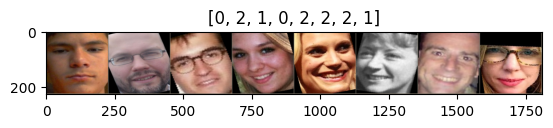

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get one batch of data
data_iter = iter(train_loader)  
images, labels = next(data_iter) 
images, labels = images.to(device), labels.to(device)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image Classes: {labels}")

class_counts = torch.bincount(labels, minlength=4)

for class_idx, count in enumerate(class_counts):
    print(f"Class {class_idx} Images: {count.item()}")
n = 8

# Make a grid from batch
out = images[:n]  # Take the first 'n' images

imshow(out, title=[x.item() for x in labels[:n]])


# Model Training

## Using Pytorch pretrained ResNet model - trained on ImageNet

In [10]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# This is just for logging during training
if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'

Number of features from pre-trained model 2048


### Add a fully connected layer
- Freeze weights for existing parameters of pretrained model
    - These dont need retrained since we are doing transfer learning
- Add a fully connected linear layer
    - This maps from the output of the pretrained model (512 for ResNet-18 / 2048 for ResNet-50)
    - To the output we want for our classifier (1 - the probability of being a certain class)
- The weights in this layer will be trained to fit our data

In [11]:
train_on_l4 = True
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze all residual blocks in the fourth layer
# For resnet-18 that is 2 blocks, for resnet50 that is 3 blocks
if train_on_l4:
    for name, param in model.layer4.named_parameters(): 
        print(name)
        param.requires_grad = True
        train_on_l4 = True
    
# Add a fully connected linear layer which transforms from 512 nodes -> 4 node
# Now that we are doing multiclass classification, we need 4 output nodes
model.fc = nn.Linear(num_features, 4)

for param in model.fc.parameters():
    param.requires_grad = True


# This is just to store a string for saving the model after training
print("\nSetup:")
if train_on_l4:
    train_type = 'fc+layer4'
else:
    train_type = 'fc'

print(train_type)
print(resnet_arch)

0.conv1.weight
0.bn1.weight
0.bn1.bias
0.conv2.weight
0.bn2.weight
0.bn2.bias
0.conv3.weight
0.bn3.weight
0.bn3.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.weight
1.bn1.weight
1.bn1.bias
1.conv2.weight
1.bn2.weight
1.bn2.bias
1.conv3.weight
1.bn3.weight
1.bn3.bias
2.conv1.weight
2.bn1.weight
2.bn1.bias
2.conv2.weight
2.bn2.weight
2.bn2.bias
2.conv3.weight
2.bn3.weight
2.bn3.bias

Setup:
fc+layer4
ResNet50


In [12]:
print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.parameters() if param.requires_grad==True])}")

Number of Learnable Parameters:  14972932


### Train and Test functions

In [13]:
def train(model, device, train_loader, optimizer, criterion, epoch, writer, verbose=0):

    model.train()
    epoch_loss = 0 # Keep track of total loss over this epoch
    if verbose:
        print('Train')
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        
        # Forward Pass
        output = model(data)

        # Compute Loss
        loss = criterion(output, target) 
        
        if verbose:
            print(f"Batch {batch_idx}: Loss = {loss:.4f}")
        epoch_loss += loss.item()
        
        # Backwards pass and optimisation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0 and not verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = epoch_loss / len(train_loader)
    if verbose:
        print(f"Avg loss = {epoch_loss:.4f} / {len(train_loader)} = {avg_loss:.4f}")

    writer.add_scalar('Train', epoch_loss / len(train_loader), epoch)

In [14]:
def val(model, device, val_loader, criterion, epoch, writer, verbose=0):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data) # Raw logits for each class. e.g. [..., ..., ..., ...]
            
            # Compute loss
            # Cross entropy loss of raw logits and target class
            batch_loss = criterion(output, target).item()
            
            if verbose == 1:
                print(f"Batch {i}: Loss = {batch_loss:.4f}")
                
            val_loss += batch_loss
            
            # Apply softmax to get prediction
            probs = torch.softmax(output,dim=1)
            pred = probs.argmax(dim=1)
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target).sum().item()

    # Average the val loss over the entire dataset
    avg_loss = val_loss/len(val_loader)

    
    # Print results
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    writer.add_scalars('Val', {
        'Loss': avg_loss,
        'Accuracy': correct / len(val_loader.dataset)
    }, epoch)
    return val_loss

In [15]:
%reload_ext tensorboard

In [16]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# optimizer = optim.SGD(model.parameters(), lr=0.001)

now = datetime.now()
log_dir = "./logs/multiclass/" + now.strftime("%Y%m%d-%H%M%S-") + resnet_arch +"_"+ train_type+ "/"
writer = SummaryWriter(log_dir=log_dir, comment='Training Logs')

for epoch in range(1, 50 + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    val_loss = val(model, device, val_loader, criterion, epoch, writer)
    #scheduler.step(val_loss)

writer.close()

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.399430
Train Epoch: 1 [1280/3920 (32%)]	Loss: 1.367767
Train Epoch: 1 [2560/3920 (65%)]	Loss: 1.361245
Train Epoch: 1 [2400/3920 (97%)]	Loss: 1.321618

Validation set: Average loss: 1.3215, Accuracy: 525/1438 (37%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 1.297993
Train Epoch: 2 [1280/3920 (32%)]	Loss: 1.293010
Train Epoch: 2 [2560/3920 (65%)]	Loss: 1.240754
Train Epoch: 2 [2400/3920 (97%)]	Loss: 1.118192

Validation set: Average loss: 1.2290, Accuracy: 616/1438 (43%)

Train Epoch: 3 [0/3920 (0%)]	Loss: 1.171778
Train Epoch: 3 [1280/3920 (32%)]	Loss: 1.075133
Train Epoch: 3 [2560/3920 (65%)]	Loss: 1.088130
Train Epoch: 3 [2400/3920 (97%)]	Loss: 1.092823

Validation set: Average loss: 1.1338, Accuracy: 680/1438 (47%)

Train Epoch: 4 [0/3920 (0%)]	Loss: 1.089863
Train Epoch: 4 [1280/3920 (32%)]	Loss: 1.087481
Train Epoch: 4 [2560/3920 (65%)]	Loss: 1.007134
Train Epoch: 4 [2400/3920 (97%)]	Loss: 1.011200

Validation set: Average loss: 1.0907, Accuracy: 712/

In [18]:
parameter_version = 'v1'
torch.save(model.state_dict(), "./models/multiclass/"  + resnet_arch +"_" + train_type + "_" + now.strftime("%Y-%m-%d") + "_" +parameter_version+ ".pth")
print("Saved model to ./models/multiclass/"  + resnet_arch +"_" +train_type + "_" + now.strftime("%Y-%m-%d") + "_" + parameter_version +".pth")

Saved model to ./models/multiclass/ResNet50_fc+layer4_2025-02-05_v1.pth


In [17]:
%tensorboard --logdir=./logs/multiclass --host localhost --port 7024

# Test Evaluation

In [25]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data) # Raw logits for each class. e.g. [..., ..., ..., ...]
            
            # Compute loss
            # Cross entropy loss of raw logits and target class
            batch_loss = criterion(output, target).item()

            test_loss += batch_loss
            
            # Apply softmax to get prediction
            probs = torch.softmax(output,dim=1)
            pred = probs.argmax(dim=1)
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [26]:
test_loss, test_accuracy = test(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.4143, Test Accuracy: 41.9037


# Visualise Predictions

In [21]:
def visualize_model(model, num_images=6, show_fails=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 0.150


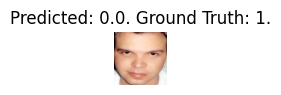

Confidence / Model Output: 0.868


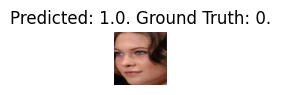

Confidence / Model Output: 0.677


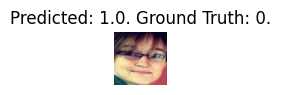

Confidence / Model Output: 0.042


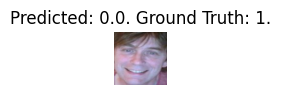

Confidence / Model Output: 0.002


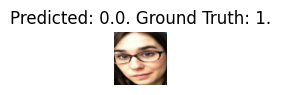

Confidence / Model Output: 0.643


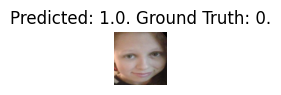

Confidence / Model Output: 0.648


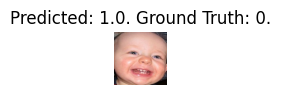

Confidence / Model Output: 0.302


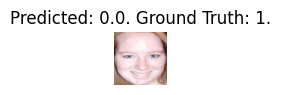

Confidence / Model Output: 0.174


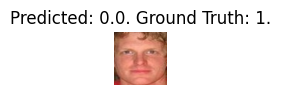

Confidence / Model Output: 0.968


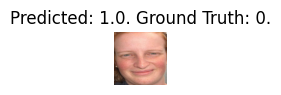

Confidence / Model Output: 0.000


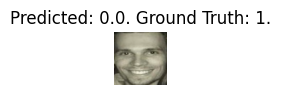

Confidence / Model Output: 1.000


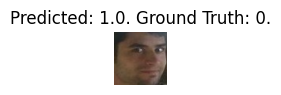

In [22]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=12, show_fails=True)